In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

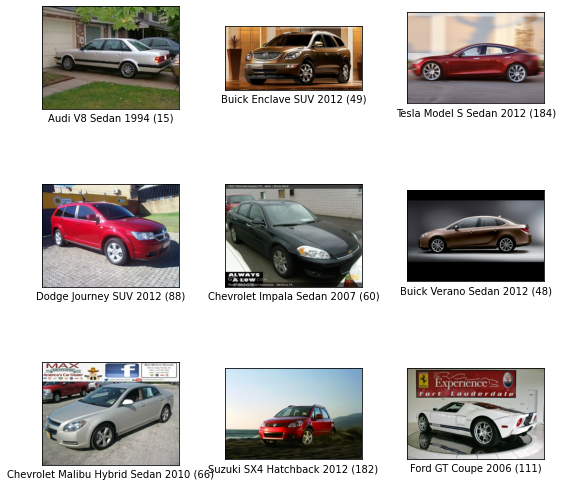

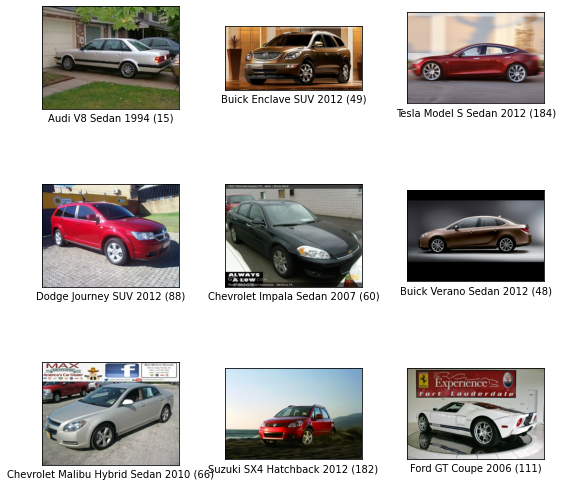

In [4]:
tfds.show_examples(ds_train, ds_info)

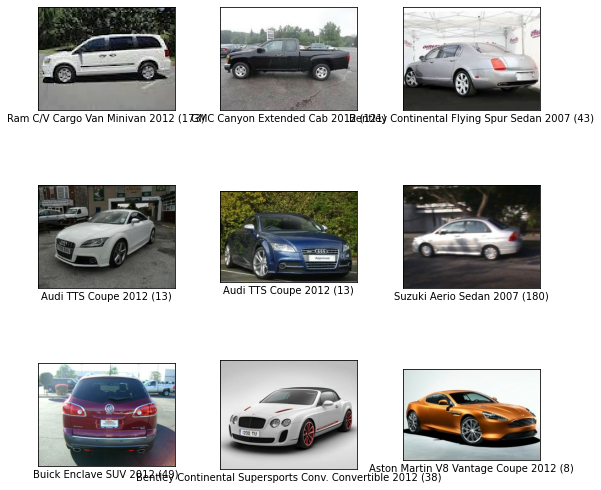

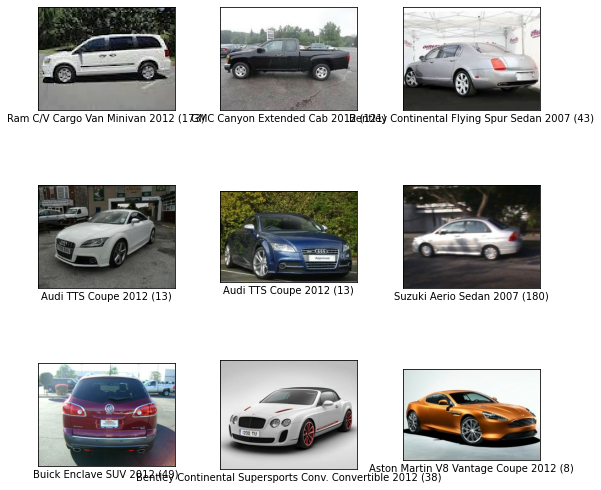

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

먼저 image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스입니다. 몇 번 보신 적 있으신가요? 그런데 조금 새로운 키(key)가 있습니다. bbox는 무엇일까요? bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 BBoxFeature이라는 타입으로 정의되어 있습니다.

CAM이란 CNN 레이어를 통과한 feature map 마다 global average pooling을 적용한 후 소프트맥스 레이어를 적용 하여 피쳐맵 마다의 중요도를 결정하여 시각화하는 것. 클래스 별로 소프트맥스 레이어를 통해 각 채널의 가중합을 구하면 각 클래스가 활성화 맵의 어떤 부분을 주로 활성화 시키는지 확인할 수 있다. 

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

conv5_block3_out의 output이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 된다.

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=30,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
509/509 [==============================] - 107s 161ms/step - loss: 4.9537 - accuracy: 0.0627 - val_loss: 5.5023 - val_accuracy: 0.0049
Epoch 2/30
509/509 [==============================] - 95s 186ms/step - loss: 2.0857 - accuracy: 0.5350 - val_loss: 1.7751 - val_accuracy: 0.5428
Epoch 3/30
509/509 [==============================] - 81s 160ms/step - loss: 0.7609 - accuracy: 0.8537 - val_loss: 1.2351 - val_accuracy: 0.6755
Epoch 4/30
509/509 [==============================] - 81s 160ms/step - loss: 0.2197 - accuracy: 0.9752 - val_loss: 1.0950 - val_accuracy: 0.7110
Epoch 5/30
509/509 [==============================] - 81s 160ms/step - loss: 0.0577 - accuracy: 0.9976 - val_loss: 1.0493 - val_accuracy: 0.7209
Epoch 6/30
509/509 [==============================] - 82s 161ms/step - loss: 0.0409 - accuracy: 0.9988 - val_loss: 1.0184 - val_accuracy: 0.7308
Epoch 7/30
509/509 [==============================] - 80s 157ms/step - loss: 0.0220 - accuracy: 0.9995 - val_loss: 1.0143 - val_a

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

120


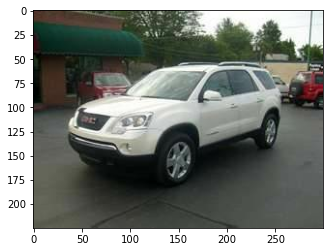

In [44]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [45]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

## CAM 구현하기

In [46]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

### CAM 이미지 생성

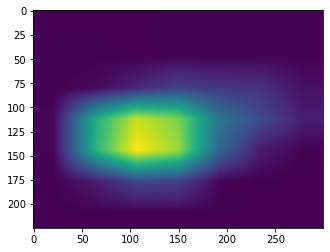

In [47]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

### visualize_cam_on_image() 함수 만들기

In [48]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

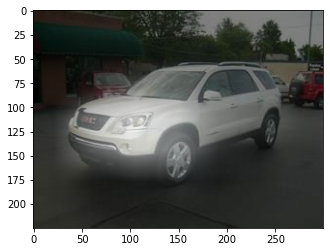

In [49]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

In [50]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

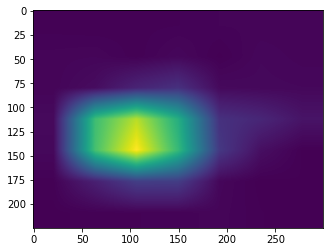

In [51]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

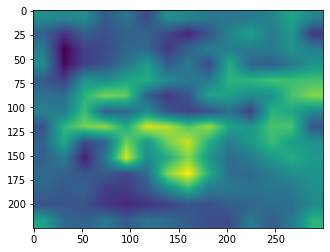

In [52]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

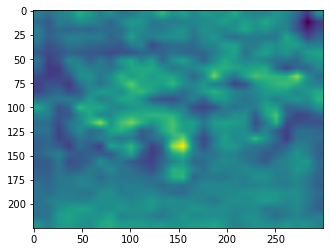

In [53]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## CAM에서 물체의 위치를 찾는 detection 하기
- cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화

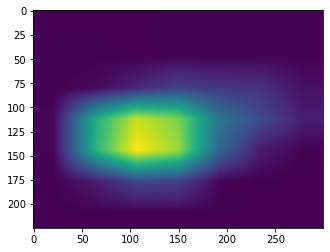

In [54]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [55]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [56]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 24, 199],
       [ 24,  55],
       [298,  55],
       [298, 199]])

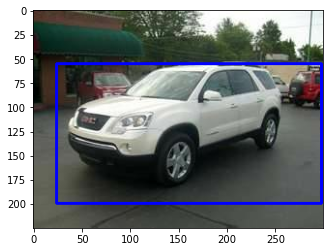

In [57]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

## IoU

In [58]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [59]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.24444444444444444, 0.08, 0.8844444444444445, 0.9933333333333333]

In [60]:
item['bbox']

array([0.22666667, 0.11333334, 0.83111113, 0.87      ], dtype=float32)

In [61]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [62]:
get_iou(pred_bbox, item['bbox'])

0.742344717450243

## Grad-CAM에서 바운딩 박스 구하기
### 1. conv5_block3_out

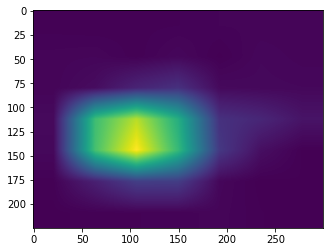

In [63]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [64]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image)
rect

array([[ 23,  58],
       [275,  58],
       [275, 199],
       [ 23, 199]])

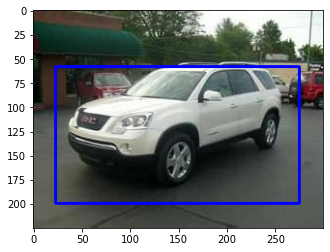

In [65]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [66]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.2577777777777778,
 0.07666666666666666,
 0.8844444444444445,
 0.9166666666666666]

In [67]:
item['bbox']

array([0.22666667, 0.11333334, 0.83111113, 0.87      ], dtype=float32)

In [68]:
get_iou(pred_bbox, item['bbox'])

0.7888527320677876

### 2. conv4_block3_out

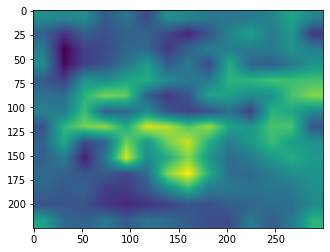

In [71]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

rect :  [[109 214]
 [140 214]
 [140 224]
 [109 224]]
pred_bbox : [0.9511111111111111, 0.36333333333333334, 0.9955555555555555, 0.4666666666666667]
item['bbox'] : [0.22666667 0.11333334 0.83111113 0.87      ]
Grad-CAM iou : 0.0


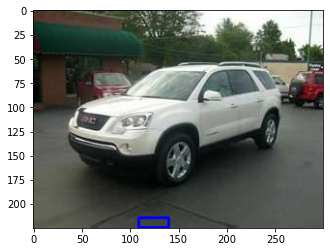

In [73]:
image = copy.deepcopy(item['image'])

rect = get_bbox(grad_cam_image)
print('rect : ',rect)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

pred_bbox = rect_to_minmax(rect, item['image'])
print('pred_bbox :',pred_bbox)

print("item['bbox'] :", item['bbox'])
print('Grad-CAM iou :', get_iou(pred_bbox, item['bbox']))

### 3. conv3_block3_out

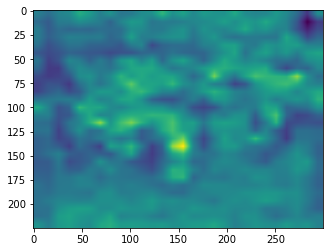

In [74]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

rect :  [[183 224]
 [183 219]
 [190 219]
 [190 224]]
pred_bbox : [0.9733333333333334, 0.61, 0.9955555555555555, 0.6333333333333333]
item['bbox'] : [0.22666667 0.11333334 0.83111113 0.87      ]
Grad-CAM iou : 0.0


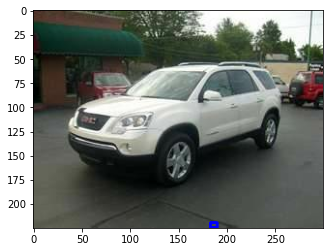

In [75]:
image = copy.deepcopy(item['image'])

rect = get_bbox(grad_cam_image)
print('rect : ',rect)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

pred_bbox = rect_to_minmax(rect, item['image'])
print('pred_bbox :',pred_bbox)

print("item['bbox'] :", item['bbox'])
print('Grad-CAM iou :', get_iou(pred_bbox, item['bbox']))

## CAM, Grad-CAM 결과 비교
- CAM의 IoU는 0.742, Grad-CAM의 IoU는 0.7888가 나왔다. Grad-CAM의 IoU가 더 좋은 것을 확인할 수 있다.
- Grad-CAM을 conv레이어 별로 확인하고 이를 통해 bounding box를 구했을 때, conv5만 잘 생성되고 conv4, conv3은 잘 생성되지 않았다. bounding box는 끝단의 conv 레이어에서 구할 수 있다는 것을 알았다.

## bounding box와 Grad-CAM 동시에 시각화 해보기

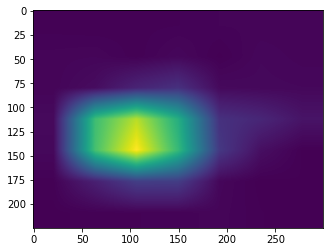

In [76]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [77]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image)
rect

array([[ 23,  58],
       [275,  58],
       [275, 199],
       [ 23, 199]])

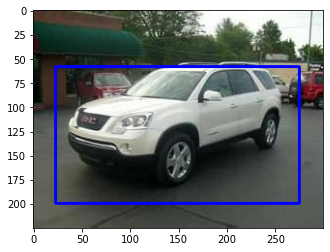

In [78]:
boxing_image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(boxing_image)

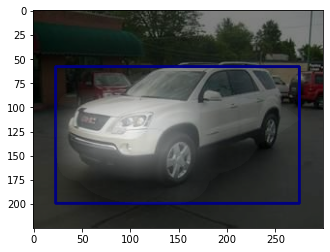

In [79]:
boxing_image = boxing_image.astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, boxing_image)
plt.imshow(blended_image)

# 마치며..
- cars196 데이터셋을 다운로드 받을 때 계속 downloaderror가 발생하여 영석퍼실님이 알려주신 자료실에서 직접 다운로드 받고 tensorflow_dataset 폴더에 압축을 풀어 저장하였더니 에러가 해결되었다. 설명가능한 AI, CAM은 정말 나중에 가면 갈수록 각광받는 딥러닝 모델일 것 같다.